In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/resnet_classifier

/content/drive/MyDrive/resnet_classifier


In [3]:
!pwd

/content/drive/MyDrive/resnet_classifier


In [4]:
!ls

bangs				  celeba-smile-valid.csv
bangs_0				  hair_color
bangs_1				  hair_color_0
bangs_classifier.ipynb		  hair_color_1
bangs_ResNet18_1.pth		  hair_color_classifier.ipynb
celeba-bangs-test.csv		  hair_color_ResNet18_1.pth
celeba-bangs-train.csv		  resnet_classifier_celeba_bangs.ipynb
celeba-bangs-valid.csv		  resnet_classifier_celeba_hair_color.ipynb
celeba-hair-color-test.csv	  resnet_classifier_celeba_smile.ipynb
celeba-hair-color-train.csv	  smile
celeba-hair-color-valid.csv	  smile_0
CelebA-HQ-img			  smile_1
CelebA-HQ-img-elleme-dolu	  smile_classifier.ipynb
CelebAMask-HQ-attribute-anno.txt  smile_preds.pt
celeba-smile-test.csv		  smile_ResNet18_1.pth
celeba-smile-train.csv


In [5]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models

import time

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [8]:
# Hyperparameters
RANDOM_SEED = 7
LEARNING_RATE = 0.01

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE = 480
GRAYSCALE = False

Dataset Preparation

Change Hair-Color column to involve the three hair color types.

In [9]:
path_1 = r'/content/drive/MyDrive/resnet_classifier/hair_color_0'
path_2 = r'/content/drive/MyDrive/resnet_classifier/hair_color_1'

In [10]:
list_1 = []
list_2 = []

In [11]:
for path in os.listdir(path_1):
    if os.path.isfile(os.path.join(path_1,path)):
        list_1.append(path)

In [12]:
for path in os.listdir(path_2):
    if os.path.isfile(os.path.join(path_2,path)):
        list_2.append(path)

In [13]:
label_1 = []
label_2 = []

In [14]:
for i in range(len(list_1)):
    label_1.append(0)

In [15]:
for i in range(len(list_2)):
    label_2.append(1)

In [16]:
split_1 = []
split_2 = []

In [17]:
for i in range(int(3*len(list_1)/5)):
    split_1.append(0)
    split_2.append(0)

In [18]:
for i in range(int(len(list_1)/5)):
    split_1.append(1)
    split_2.append(1)

In [19]:
for i in range(int(len(list_1)/5)):
    split_1.append(2)
    split_2.append(2)

In [20]:
df_hair_0 = pd.DataFrame(list_1,columns=['Filename'])
df_hair_0 = df_hair_0.set_index('Filename')
df_hair_0['Blond_Hair'] = label_1
df_hair_0['Partition'] = split_1
print(df_hair_0)
print(df_hair_0.iloc[5])

           Blond_Hair  Partition
Filename                        
43.jpg              0          0
101.jpg             0          0
178.jpg             0          0
185.jpg             0          0
237.jpg             0          0
...               ...        ...
29281.jpg           0          2
29523.jpg           0          2
29675.jpg           0          2
29676.jpg           0          2
29705.jpg           0          2

[240 rows x 2 columns]
Blond_Hair    0
Partition     0
Name: 496.jpg, dtype: int64


In [21]:
df_hair_1 = pd.DataFrame(list_2,columns=['Filename'])
df_hair_1 = df_hair_1.set_index('Filename')
df_hair_1['Blond_Hair'] = label_2
df_hair_1['Partition'] = split_2
print(df_hair_1)
print(df_hair_1.iloc[5])

           Blond_Hair  Partition
Filename                        
122.jpg             1          0
125.jpg             1          0
131.jpg             1          0
262.jpg             1          0
334.jpg             1          0
...               ...        ...
29200.jpg           1          2
29543.jpg           1          2
29666.jpg           1          2
29674.jpg           1          2
29957.jpg           1          2

[240 rows x 2 columns]
Blond_Hair    1
Partition     0
Name: 368.jpg, dtype: int64


In [22]:
dataframes_hair_initial = [df_hair_0,df_hair_1]
dataframes_hair = pd.concat(dataframes_hair_initial)

In [23]:
print(dataframes_hair)

           Blond_Hair  Partition
Filename                        
43.jpg              0          0
101.jpg             0          0
178.jpg             0          0
185.jpg             0          0
237.jpg             0          0
...               ...        ...
29200.jpg           1          2
29543.jpg           1          2
29666.jpg           1          2
29674.jpg           1          2
29957.jpg           1          2

[480 rows x 2 columns]


In [24]:
dataframes_hair.loc[dataframes_hair['Partition'] == 0].to_csv('celeba-hair-color-train.csv')
dataframes_hair.loc[dataframes_hair['Partition'] == 1].to_csv('celeba-hair-color-valid.csv')
dataframes_hair.loc[dataframes_hair['Partition'] == 2].to_csv('celeba-hair-color-test.csv')

(1024, 1024, 3)


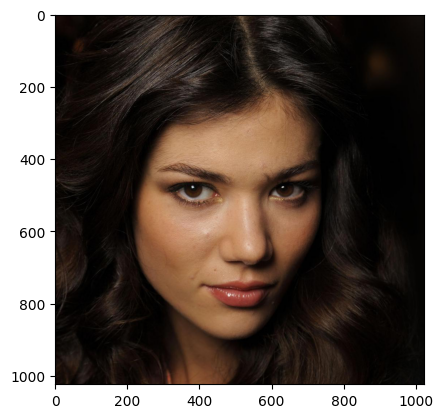

In [25]:
img = Image.open('hair_color/237.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

DataLoader

In [9]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Blond_Hair'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [10]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
                                    ])

train_dataset = CelebaDataset(csv_path='celeba-hair-color-train.csv',
                              img_dir='hair_color/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-hair-color-valid.csv',
                              img_dir='hair_color/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-hair-color-test.csv',
                             img_dir='hair_color/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

print('Train dataloader size:', len(train_loader))
print('Test dataloader size:', len(test_loader))

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

Train dataloader size: 1
Test dataloader size: 1
Train dataset size: 288
Test dataset size: 96


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])


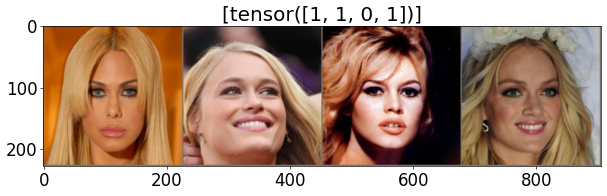

In [16]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_loader)

# visualize a batch of train image
inputs, classes = next(iterator)
print(classes)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out,title=[classes[:4]])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [31]:
num_epochs = 5
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 0.7699 Acc: 48.6111% Time: 13.7402s
[Test #0] Loss: 0.7008 Acc: 58.3333% Time: 41.1327s
[Train #1] Loss: 0.6662 Acc: 56.2500% Time: 47.5696s
[Test #1] Loss: 0.6574 Acc: 56.2500% Time: 50.4382s
[Train #2] Loss: 0.5686 Acc: 71.1806% Time: 58.2758s
[Test #2] Loss: 0.5528 Acc: 71.8750% Time: 60.7949s
[Train #3] Loss: 0.4446 Acc: 85.4167% Time: 69.0464s
[Test #3] Loss: 0.4616 Acc: 84.3750% Time: 71.4949s
[Train #4] Loss: 0.3576 Acc: 90.6250% Time: 77.8486s
[Test #4] Loss: 0.4049 Acc: 84.3750% Time: 81.2069s


In [13]:
save_path = 'hair_color_ResNet18_1.pth'
torch.save(model.state_dict(), save_path)

In [14]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

[Prediction Result Examples]


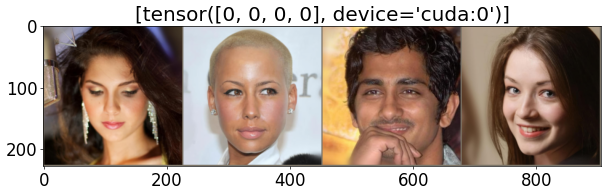

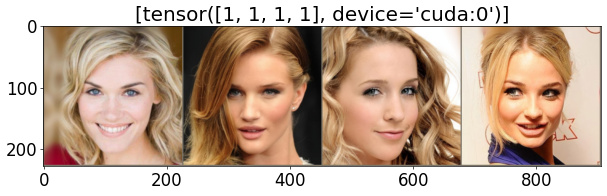

[Test #4] Loss: 0.4049 Acc: 84.3750% Time: 3.0741s


In [34]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[8:12])
            imshow(images.cpu(), title=[labels[8:12]])
            images = torchvision.utils.make_grid(inputs[92:96])
            imshow(images.cpu(), title=[labels[92:96]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

**For feeding to train_boundary**

[Prediction Result Examples]


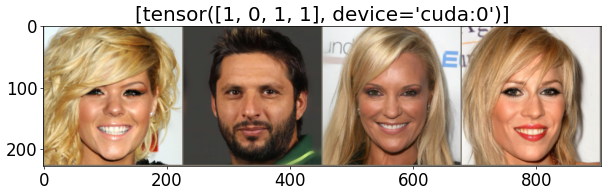

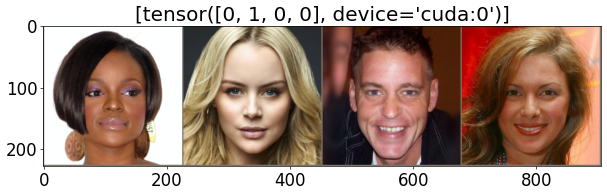

Preds: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       device='cuda:0')
Len of p

In [17]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[8:12])
            imshow(images.cpu(), title=[labels[8:12]])
            images = torchvision.utils.make_grid(inputs[12:16])
            imshow(images.cpu(), title=[labels[12:16]])


    print("Preds:", preds)
    print("Len of preds:", len(preds))

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    #print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    train_preds = preds

[Prediction Result Examples]


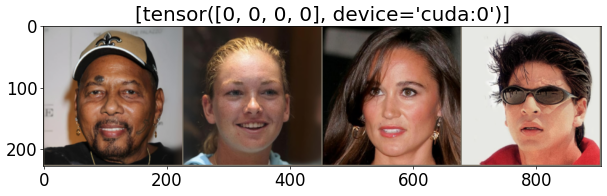

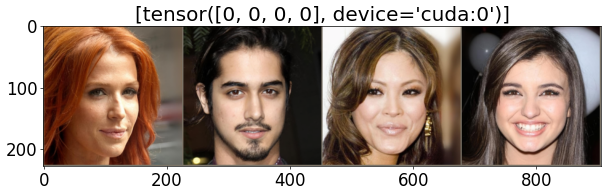

Preds: tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       device='cuda:0')
Len of preds: 96


In [18]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(valid_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[8:12])
            imshow(images.cpu(), title=[labels[8:12]])
            images = torchvision.utils.make_grid(inputs[12:16])
            imshow(images.cpu(), title=[labels[12:16]])


    print("Preds:", preds)
    print("Len of preds:", len(preds))

    #print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    valid_preds = preds

[Prediction Result Examples]


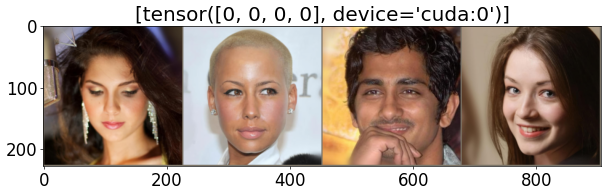

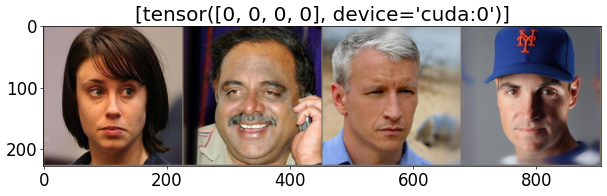

Preds: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Len of preds: 96


In [19]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[8:12])
            imshow(images.cpu(), title=[labels[8:12]])
            images = torchvision.utils.make_grid(inputs[12:16])
            imshow(images.cpu(), title=[labels[12:16]])


    print("Preds:", preds)
    print("Len of preds:", len(preds))

    
    #print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    test_preds = preds

In [20]:
hair_color_preds = torch.cat((train_preds, valid_preds, test_preds))

In [21]:
print(hair_color_preds)
print(len(hair_color_preds))

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,

In [22]:
torch.save(hair_color_preds, 'hair_color_preds.pt')